## Methodology Used 
1. Preparing the Training and Test Dataset by applying Sobel filter on dataset using OpenCV.
<br>
2. Training the Model on the dataset.<br>
    a. Model Architecture: I have used 3 Convolution Layers along with Max Pooling layers with ReLU activation Function to capture the edges in the image. Moreover, 3 Convolution Transpose Layers are used to restore the shape of the model output to Image size.
<br>
3. Testing the Model <br>The Model is tested on a 2500 images sampled randomly from the dataset.

## Importing the Required Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision

from PIL import Image

## Dataset Preperation

In [3]:
data = os.path.join('natural_images') # path to the dataset
X_train = []
labels = []
for folders in os.listdir(data):
    for images in os.listdir(os.path.join(data, folders)):
        img = cv2.imread(os.path.join(data, folders, images))
        img = cv2.resize(img, (150, 150))
        X_train.append(img)
        labels.append(folders)

In [4]:
X_train=np.array(X_train)
labels=np.array(labels)
print("The shape of the training data is: ", X_train.shape)
print("The shape of the labels is: ", labels.shape)

The shape of the training data is:  (6899, 150, 150, 3)
The shape of the labels is:  (6899,)


In [5]:
# Convert original images to grayscale for better training
X_train_gray = np.zeros((X_train.shape[0], 150, 150))
for i in range(X_train.shape[0]):
    X_train_gray[i] = cv2.cvtColor(X_train[i], cv2.COLOR_BGR2GRAY)
    

### Preparing the Testing dataset by applying Sobel Filter using OpenCV

In [6]:
sobel_images = []
for image in X_train:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    sobel_images.append(sobel)

In [8]:
sobel_images = np.array(sobel_images)
print("The shape of the sobel images is: ", sobel_images.shape)
print("The shape of train_data is ", X_train_gray.shape)

The shape of the sobel images is:  (6899, 150, 150)
The shape of train_data is  (6899, 150, 150)


### Spltting the dataset into Train and Test

In [9]:
test_idx = np.random.choice(X_train.shape[0], 2500, replace=False)  # Randomly select 2500 images for testing
x_test = X_train_gray[test_idx]
y_test = sobel_images[test_idx]
x_train = np.delete(X_train_gray, test_idx, axis=0)
y_train = np.delete(sobel_images, test_idx, axis=0)

In [10]:
print("The shape of the training data is: ", x_train.shape)
print("The shape of the labels is: ", y_train.shape)
print("The shape of the test data is: ", x_test.shape)
print("The shape of the labels is: ", y_test.shape)

The shape of the training data is:  (4399, 150, 150)
The shape of the labels is:  (4399, 150, 150)
The shape of the test data is:  (2500, 150, 150)
The shape of the labels is:  (2500, 150, 150)


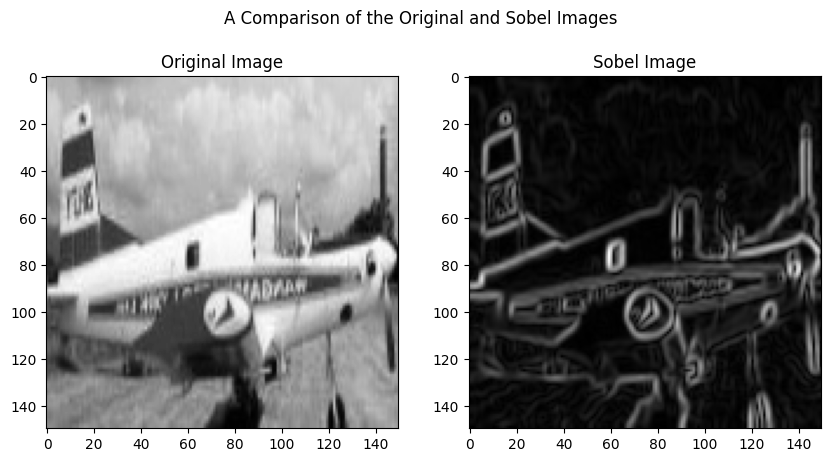

In [38]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_train_gray[42],cmap='gray')
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(sobel_images[42], cmap='gray')
plt.title("Sobel Image")
plt.suptitle("A Comparison of the Original and Sobel Images")
plt.show()

In [12]:
print(x_train.shape, y_train.shape)

(4399, 150, 150) (4399, 150, 150)


## Model Development

### Making Dataloader
Making Dataloader using PyTorch DataLoader to get an iterable over the training dataset. <br>

Moreover, the data is normalised to range [-1,1] to achieve better and efficient training of the model.

In [13]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),  # Converts the image to a tensor and scales pixel values to [0, 1]
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])  # Normalizes the image to mean 0.5 and standard deviation 0.5
])

class ImageDataset():
    def __init__(self, x_train, y_train,transform):
        self.x_train = x_train
        self.y_train = y_train
        self.transform = transform

    def __len__(self):
        return len(self.x_train)

    def __getitem__(self, idx):
        
        original_np = np.array(self.x_train[idx], dtype=np.float32)  # Convert to NumPy arrays
        sobel_np = np.array(self.y_train[idx], dtype=np.float32)

        original_img = Image.fromarray(original_np)   # Convert to PIL Images
        sobel_img = Image.fromarray(sobel_np)

        if self.transform:  # Apply transformations
            original_img = self.transform(original_img)
            sobel_img = self.transform(sobel_img)

        original = torch.tensor(np.array(original_img), dtype=torch.float32)   # Convert back to tensors and normalize
        sobel = torch.tensor(np.array(sobel_img), dtype=torch.float32)


        original = (original - original.min()) / (original.max() - original.min()) * 2 - 1  # Normalize both images to range [-1, 1]
        sobel = (sobel - sobel.min()) / (sobel.max() - sobel.min()) * 2 - 1

        return original, sobel



In [14]:
dataset = ImageDataset(x_train, y_train,transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)  # Create a DataLoader

### Defining Model Architecture

The model consists of several convolutional and transposed convolutional layers designed to capture patterns and reconstruct images.
- **Conv2d layers:** Learn spatial patterns and features and detecting edges.
- **MaxPool layers:** To simplify the model
- **DropuOut layer:** To prevent Overfitting
- **ReLU activations:** Introduce non-linearity to capture complex patterns.
- **ConvTranspose2d layers:** Upsample the feature maps to reconstruct the output.


In [17]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.5),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.5),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=2),
            nn.Upsample(size=(150, 150), mode='bilinear', align_corners=False),
        )
    def forward(self, x):
        return self.layers(x)
      

### Initializing the Model and defining Training Criterion

In [18]:
model = Net()  # Initialize the Model
device = torch.device('cpu')  # Use the CPU to train the model. Change to 'cuda' if a GPU is available 
model.to(device)
criterion = nn.MSELoss()  # Define the loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3) # Define the optimizer


In [19]:
print(model)

Net(
  (layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.5, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (12): ReLU()
    (13): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (14): ReLU()
    (15): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2))
    (16): Upsample(size=(150, 150), mode='bilinear')
  )
)


### Training the Model for 15 epochs
(Number of epochs can be increased. But due to GPU limitaion, it is kept to 15)

In [20]:
# Training loop
num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (original, sobel) in enumerate(dataloader):

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(original)
        loss = criterion(outputs, sobel)

        # Backward pass and stepping up the optimizer
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}')

    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {running_loss/len(dataloader):.4f}')

print('Finished Training')

Epoch [1/15], Step [10/138], Loss: 0.3417
Epoch [1/15], Step [20/138], Loss: 0.2082
Epoch [1/15], Step [30/138], Loss: 0.1772
Epoch [1/15], Step [40/138], Loss: 0.1724
Epoch [1/15], Step [50/138], Loss: 0.1460
Epoch [1/15], Step [60/138], Loss: 0.1245
Epoch [1/15], Step [70/138], Loss: 0.1166
Epoch [1/15], Step [80/138], Loss: 0.1004
Epoch [1/15], Step [90/138], Loss: 0.0857
Epoch [1/15], Step [100/138], Loss: 0.0825
Epoch [1/15], Step [110/138], Loss: 0.0822
Epoch [1/15], Step [120/138], Loss: 0.0788
Epoch [1/15], Step [130/138], Loss: 0.0750
Epoch [1/15], Average Loss: 0.1654
Epoch [2/15], Step [10/138], Loss: 0.0738
Epoch [2/15], Step [20/138], Loss: 0.0794
Epoch [2/15], Step [30/138], Loss: 0.0714
Epoch [2/15], Step [40/138], Loss: 0.0734
Epoch [2/15], Step [50/138], Loss: 0.0715
Epoch [2/15], Step [60/138], Loss: 0.0683
Epoch [2/15], Step [70/138], Loss: 0.0649
Epoch [2/15], Step [80/138], Loss: 0.0682
Epoch [2/15], Step [90/138], Loss: 0.0747
Epoch [2/15], Step [100/138], Loss: 0

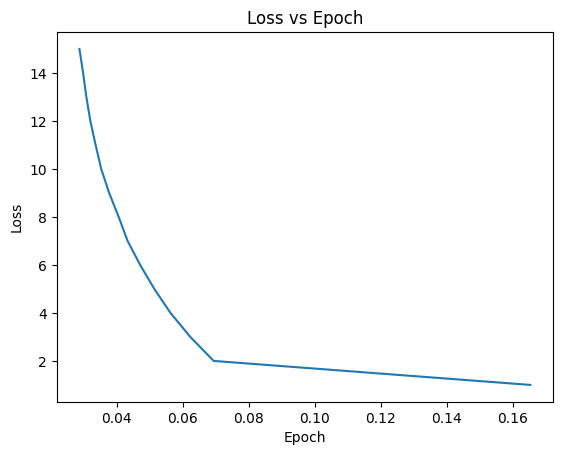

In [69]:
# Visualising the Losses
losses = [0.1654, 0.0694, 0.0623, 0.0563, 0.0514, 0.0471, 0.0433, 0.0406, 0.0377, 0.0353, 0.0336, 0.0320, 0.0308, 0.0298, 0.0287]
epoch = np.arange(1,16,1)
plt.plot(losses, epoch)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.show()

In [43]:
def denormalize(tensor, min_val, max_val):  # Denormalizing the output to the range of the Image values
    
    return ((tensor + 1) / 2) * (max_val - min_val) + min_val

### Preparing the Test DataLoader

In [50]:
test_dataset = ImageDataset(x_test, y_test,transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # Create a DataLoader for testing

### Testing the model on Test Data

In [60]:
model.eval()  # Set the model to evaluation mode
test_loss = 0. 
output_images = []
with torch.no_grad():  # Disable gradient tracking
    for original, sobel in test_loader:
        outputs = model(original)  # Getting prediction from Model
        loss = criterion(outputs, sobel).item() 
        test_loss += loss  # Accumulating the loss
        denormalized_outputs = denormalize(outputs, min_val=0, max_val=255)  # Denormalizing the output to Original Image size
        output_images.append(denormalized_outputs)
        denormalized_sobel = denormalize(sobel, min_val=0, max_val=255)
average_loss = test_loss / len(x_test)

In [66]:
outputs = []
for output in output_images:
    for i in range(output.size(0)):
        outputs.append(output[i])
outputs = np.array(outputs)

In [67]:
print("Shape of Output Images: ", outputs.shape)
print("Average Test Loss: ", average_loss)

Shape of Output Images:  (2500, 1, 150, 150)
Average Test Loss:  0.0020078767627477647


### An Illustration Comparing the Actual Image, Sobel filtered Image and Model Prediction

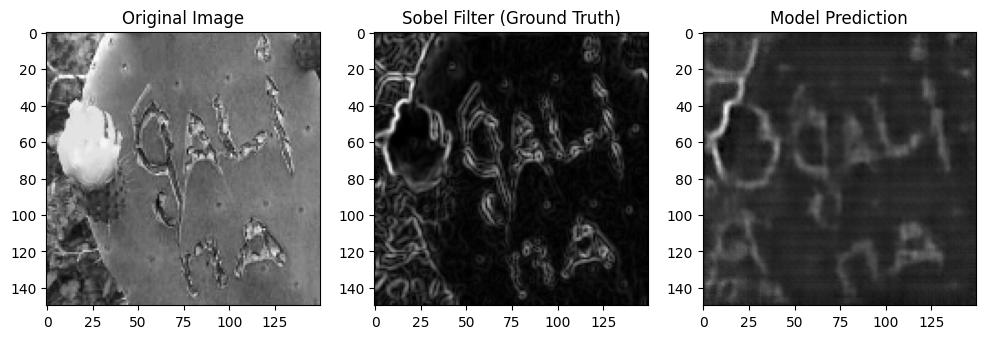

In [55]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(original[1].cpu().numpy().squeeze(), cmap='gray')
ax[0].set_title('Original Image')

ax[1].imshow(denormalized_sobel[1].cpu().numpy().squeeze(), cmap='gray')
ax[1].set_title('Sobel Filter (Ground Truth)')

ax[2].imshow(denormalized_outputs[1].cpu().numpy().squeeze(), cmap='gray')
ax[2].set_title('Model Prediction')

plt.show()

## Conclusion

### Results and Discussion
- Several different models were tried like CNN with different number of Convolutional layers, with and without dropouts, changing the kernel size and padding. THe best model till now is illustrated in the notebook
- The training loss decreased from initial value of 1 to 0.02 which suggests that model is able to recognize the patterns present in the dataset.
- By plotting the outputs and comparing with sobel filtered image, we can conclude that model is able to identify all major edges and a few minor edges. However, it cannot still get the very fine details of the image. This can be resolved by adding some Fully Connected Layers, or more Convolutional layers. However, due to limitation of computational resources, it is not done now.